In [104]:
#import packages
import numpy as np
import pennylane as qml
from pennylane import expval, var

In [105]:
dev = qml.device("default.qubit", wires=2)

#create ansatz 
def ansatz(params, wires):
    
    #parameterized layer 0
    qml.RY(params[0], wires=0)
    qml.RY(params[1], wires=1)
    
    #entanglement
    qml.CNOT(wires=[0,1])
    
    #param layer 1
    qml.RY(params[2], wires=0)
    qml.RY(params[3], wires=1)


In [120]:
alpha = 0.4
beta = 0.2
coeffs = [alpha, alpha, beta]

#H2 hamiltonian from Yamamoto 2019
obs_list = [
    qml.PauliZ(0) @ qml.Identity(1),
    qml.Identity(0) @ qml.PauliZ(1),
    qml.PauliX(0) @ qml.PauliX(1)
]

#create qnodes
qnodes = qml.map(ansatz, obs_list, dev, measure='expval')

#create cost function
cost = qml.dot(coeffs, qnodes)

In [125]:
#initialize constants
max_iterations = 200
step_size = 0.05
conv_tol = 1e-06

optimizers = ['QNG', 'Vanilla']
QNG_cost = []
vanilla_cost = []


prev_energy = cost(params)
for k in range(len(algorithms)):
    
    #Quantum Natural Gradient Descent
    if optimizers[k] == 'QNG':
        print("QUANTUM NATURAL GRADIENT")
        
        #initial params (example from Yamamoto 2019, FIG 5)
        params = np.array([-0.2,-0.2,0,0])
        
        for n in range(max_iterations):
            #compute the gradient
            gradient = qml.grad(cost, argnum=[0])
            
            #take the gradient of the params
            grad_at_point = [float(i) for i in gradient(params)[0]]
            
            #perform quantum natural gradient.
            params = params - step_size * np.dot(
                np.linalg.pinv(qnodes[0].metric_tensor([params])), 
                grad_at_point)
            
            #compute new energy with updates params
            energy = cost(params)
            QNG_cost.append(energy)
            
            #calculate convergence
            conv = np.abs(energy - prev_energy)

            if n % 20 == 0:
                print('Iteration = {:},  Ground-state energy = {:.8f} Ha,  Convergence parameter = {'
                      ':.8f} Ha'.format(n, energy, conv))

            if conv <= conv_tol:
                print("final params: ", params)
                break

            prev_energy = energy
            
    #Vanilla Gradient Descent
    if optimizers[k] == 'Vanilla':
        print("VANILLA GRADIENT")
        params = np.array([-0.2,-0.2,0,0])
        for n in range(max_iterations):
            
            gradient = qml.grad(cost, argnum=[0])
            grad_at_point = [float(i) for i in gradient(params)[0]]
            
            #calculate vanilla gradient descent
            params = params - np.dot(step_size, grad_at_point)
            
            #calculate new energy with updates params
            energy = cost(params)
            vanilla_cost.append(energy)
            
            #calculate convergence
            conv = np.abs(energy - prev_energy)

            if n % 20 == 0:
                print('Iteration = {:},  Ground-state energy = {:.8f} Ha,  Convergence parameter = {'
                      ':.8f} Ha'.format(n, energy, conv))

            if conv <= conv_tol:
                break

            prev_energy = energy

QUANTUM NATURAL GRADIENT
Iteration = 0,  Ground-state energy = 0.70579155 Ha,  Convergence parameter = 1.53038995 Ha
Iteration = 20,  Ground-state energy = -0.81912764 Ha,  Convergence parameter = 0.00201111 Ha
Iteration = 40,  Ground-state energy = -0.82454651 Ha,  Convergence parameter = 0.00001366 Ha
final params:  [-1.62068919 -1.32517619  1.51679689 -1.55267923]
VANILLA GRADIENT
Iteration = 0,  Ground-state energy = 0.72935795 Ha,  Convergence parameter = 1.55397263 Ha
Iteration = 20,  Ground-state energy = 0.41356031 Ha,  Convergence parameter = 0.02600043 Ha
Iteration = 40,  Ground-state energy = -0.24865113 Ha,  Convergence parameter = 0.03199803 Ha
Iteration = 60,  Ground-state energy = -0.65176630 Ha,  Convergence parameter = 0.01061696 Ha
Iteration = 80,  Ground-state energy = -0.76504295 Ha,  Convergence parameter = 0.00290410 Ha
Iteration = 100,  Ground-state energy = -0.79938512 Ha,  Convergence parameter = 0.00101500 Ha
Iteration = 120,  Ground-state energy = -0.81246672

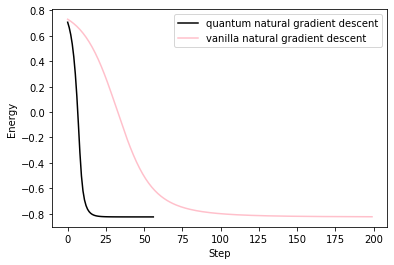

In [127]:
from matplotlib import pyplot as plt
plt.plot(QNG_cost, "black", label="quantum natural gradient descent")
plt.plot(vanilla_cost, "pink", label="vanilla natural gradient descent")

plt.ylabel("Energy")
plt.xlabel("Step")
plt.legend()
plt.show()